<a href="https://colab.research.google.com/github/asupraja3/ml-ng-notebooks/blob/main/GradientDescent_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Optional Lab: Gradient Descent for Logistic Regression

**Goals**
- Explore the gradient descent update code for logistic regression
- Visualize the cost decreasing over iterations
- Build intuition for the parameters \(w, b\) using a tiny 2‑feature toy dataset

**What you should know after this lab**
1. How the sigmoid function maps $z = w^{\top} x + b$ to probabilities
2. How to compute the logistic loss for a batch of examples
3. How to compute gradients $\frac{\partial J}{\partial w_j}$ and $\frac{\partial J}{\partial b}$ in loops and vectorized form
4. How to implement batch gradient descent and diagnose convergence


In [2]:

# ==== Imports ====
import math
import copy
import numpy as np
import matplotlib.pyplot as plt

# (No seaborn. One chart per figure.)
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["font.size"] = 12



## Data set

We'll reuse a small, two‑feature dataset in the spirit of the course's labs.
- Each example $x^{(i)} = [x_0^{(i)}, x_1^{(i)}]$  
- Labels $y^{(i)} \in \{0,1\}$

This is intentionally small so you can step through the math and the plots.


In [5]:
# Two features (x0, x1). Each row is one example.
X_train = np.array([
    [0.5, 1.5],
    [1.0, 1.0],
    [1.5, 0.5],
    [3.0, 0.5],
    [2.0, 2.0],
    [1.0, 2.5]
], dtype=float)

# Corresponding labels
y_train = np.array([0, 0, 0, 1, 1, 1], dtype=float)

m, n = X_train.shape
(m, n)


(6, 2)

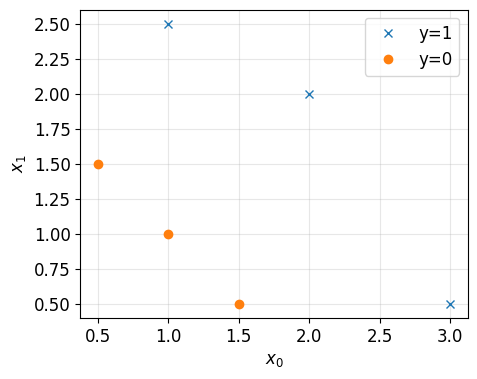

In [9]:

def plot_data(X, y):
    """Scatter-plot the tiny dataset.
"
    "We avoid setting explicit colors to follow the constraints.
"""""
    fig, ax = plt.subplots()
    pos = y == 1
    neg = y == 0
    ax.plot(X[pos, 0], X[pos, 1], 'x', label="y=1")
    ax.plot(X[neg, 0], X[neg, 1], 'o', label="y=0")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)
    plt.show()

plot_data(X_train, y_train)



## Logistic model and sigmoid

We use:  

$$
z^{(i)} = w^\top x^{(i)} + b, \qquad
\hat{y}^{(i)} = \sigma(z^{(i)}) = \frac{1}{1 + e^{-z^{(i)}}}
$$  

- $\hat{y}^{(i)}$ is interpreted as $P(y=1 \mid x^{(i)})$.  
- The decision boundary at probability $0.5$ corresponds to $w^\top x + b = 0$.



In [10]:

def sigmoid(z):
    """Numerically stable sigmoid."""
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def predict_proba(X, w, b):
    """Return probabilities for class 1 for each example in X."""
    return sigmoid(X @ w + b)



## Logistic loss (cost)

For a batch of $m$ examples:  

$$
J(w,b) = -\frac{1}{m}\sum_{i=1}^m \Big( y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \Big)
$$



In [11]:

def compute_cost_logistic(X, y, w, b):
    """Compute the average logistic loss J(w,b) over the batch."""
    m = X.shape[0]
    z = X @ w + b
    yhat = sigmoid(z)
    eps = 1e-12
    loss = -(y * np.log(yhat + eps) + (1 - y) * np.log(1 - yhat + eps))
    return np.sum(loss) / m



## Gradients — loop version (pedagogical)


In [12]:

def compute_gradient_logistic_loops(X, y, w, b):
    """Compute dJ/dw and dJ/db using explicit loops (readable)."""
    m, n = X.shape
    dj_dw = np.zeros(n, dtype=float)
    dj_db = 0.0
    for i in range(m):
        z_i = np.dot(X[i], w) + b
        yhat_i = sigmoid(z_i)
        err_i = yhat_i - y[i]
        for j in range(n):
            dj_dw[j] += err_i * X[i, j]
        dj_db += err_i
    dj_dw /= m
    dj_db /= m
    return dj_dw, dj_db



## Gradients — vectorized (fast & concise)


In [13]:

def compute_gradient_logistic_vectorized(X, y, w, b):
    """Vectorized gradient for logistic regression."""
    m = X.shape[0]
    yhat = predict_proba(X, w, b)
    err = yhat - y
    dj_dw = (X.T @ err) / m
    dj_db = np.sum(err) / m
    return dj_dw, dj_db



## Batch Gradient Descent


In [15]:

def gradient_descent_logistic(X, y, w_in, b_in, alpha, num_iters, use_vectorized=True):
    """Perform batch gradient descent for logistic regression."""
    w = w_in.copy().astype(float)
    b = float(b_in)
    J_history, trace = [], []
    for it in range(num_iters):
        if use_vectorized:
            dj_dw, dj_db = compute_gradient_logistic_vectorized(X, y, w, b)
        else:
            dj_dw, dj_db = compute_gradient_logistic_loops(X, y, w, b)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        J = compute_cost_logistic(X, y, w, b)
        J_history.append(J)
        trace.append((J, w.copy(), b))
        if num_iters <= 50 and (it % max(1, num_iters // 10) == 0):
            print(f"iter {it:4d}  J={J:.6f}  ||grad||={np.linalg.norm(dj_dw):.4e}  db={dj_db:.4e}")
    return w, b, J_history, trace



## Run it on the toy data


In [16]:

w0 = np.zeros(X_train.shape[1], dtype=float)
b0 = 0.0
alpha = 0.1
num_iters = 10000

w_out, b_out, J_hist, trace = gradient_descent_logistic(
    X_train, y_train, w0, b0, alpha, num_iters, use_vectorized=True
)
print("Learned parameters:")
print("w:", w_out)
print("b:", b_out)
print("Final cost:", J_hist[-1])


Learned parameters:
w: [5.28123029 5.07815608]
b: -14.222409982019839
Final cost: 0.017117768889275655


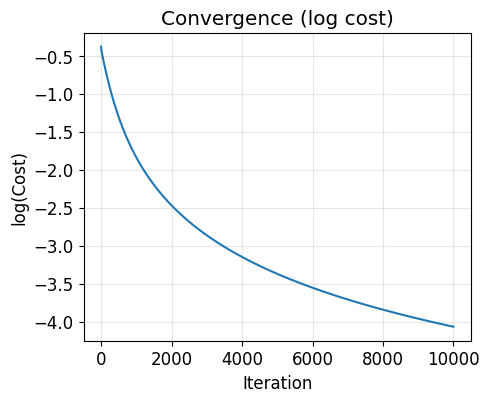

In [17]:

# Plot log(cost) vs iteration to inspect convergence
fig, ax = plt.subplots()
ax.plot(np.log(np.maximum(J_hist, 1e-20)))
ax.set_xlabel("Iteration")
ax.set_ylabel("log(Cost)")
ax.set_title("Convergence (log cost)")
ax.grid(True, alpha=0.3)
plt.show()



## Visualize probabilities and the decision boundary


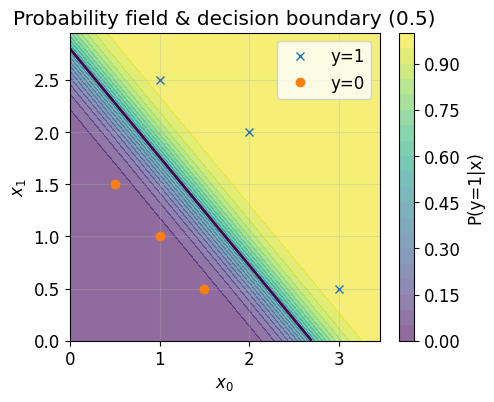

In [18]:

def predict_proba_grid(w, b, x0_min, x0_max, x1_min, x1_max, step):
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, step),
                           np.arange(x1_min, x1_max, step))
    grid = np.c_[xx0.ravel(), xx1.ravel()]
    probs = predict_proba(grid, w, b).reshape(xx0.shape)
    return xx0, xx1, probs

def plot_decision_boundary(X, y, w, b, grid_step=0.05, padding=0.5):
    x0_min, x0_max = X[:,0].min()-padding, X[:,0].max()+padding
    x1_min, x1_max = X[:,1].min()-padding, X[:,1].max()+padding
    xx0, xx1, probs = predict_proba_grid(w, b, x0_min, x0_max, x1_min, x1_max, grid_step)

    fig, ax = plt.subplots()
    cs = ax.contourf(xx0, xx1, probs, levels=20, alpha=0.6)
    cbar = fig.colorbar(cs); cbar.set_label("P(y=1|x)")
    pos = y == 1; neg = y == 0
    ax.plot(X[pos, 0], X[pos, 1], 'x', label="y=1")
    ax.plot(X[neg, 0], X[neg, 1], 'o', label="y=0")
    ax.contour(xx0, xx1, probs, levels=[0.5], linewidths=2)
    ax.set_xlabel("$x_0$"); ax.set_ylabel("$x_1$")
    ax.set_title("Probability field & decision boundary (0.5)")
    ax.legend(loc="best"); ax.grid(True, alpha=0.3)
    plt.show()

plot_decision_boundary(X_train, y_train, w_out, b_out)



## (Optional) Cost as a function of \(w_0\) and \(b\)


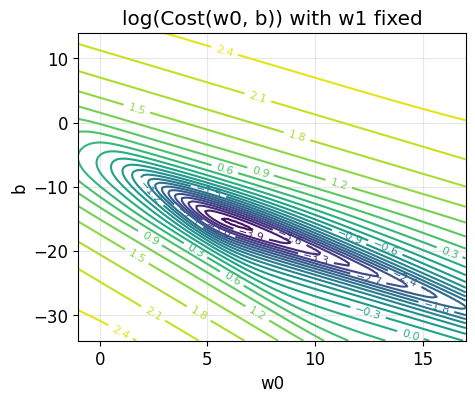

In [20]:

def plot_cost_landscape_w0_b(X, y, w, b, w0_range=(-1, 17), b_range=(-34, 14), steps=120):
    w = w.copy()
    w1_fixed = w[1]
    w0_vals = np.linspace(w0_range[0], w0_range[1], steps)
    b_vals  = np.linspace(b_range[0],  b_range[1],  steps)
    W0, B = np.meshgrid(w0_vals, b_vals)
    J = np.zeros_like(W0)
    for i in range(steps):
        for j in range(steps):
            w[0] = W0[i, j]; btmp = B[i, j]
            J[i, j] = compute_cost_logistic(X, y, w, btmp)
    fig, ax = plt.subplots()
    cs = ax.contour(W0, B, np.log(np.maximum(J, 1e-20)), levels=25)
    ax.set_xlabel("w0"); ax.set_ylabel("b")
    ax.set_title("log(Cost(w0, b)) with w1 fixed")
    plt.clabel(cs, inline=True, fontsize=8)
    ax.grid(True, alpha=0.3)
    plt.show()

plot_cost_landscape_w0_b(X_train, y_train, w_out, b_out)



## Takeaways

- Logistic regression models the log-odds linearly in the features; sigmoid maps to probability.
- Batch gradient descent updates \(w,b\) using the average gradient.
- Monitoring **log(cost)** helps diagnose convergence.
- The decision boundary is where \(w^\top x + b = 0\).
- Prefer vectorized code in practice; loops are great for learning.
